<a href="https://colab.research.google.com/github/aaperei/data-science/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network

### Alison Augusto Miranda Pereira - UNIFESP - 2022

## Descrição do problema

O presente trabalho tem o objetivo de explorar o algoritmo `CNN` (*Convolutional Neural Network*) por meio da base de dados `MNIST`.

O artigo ***PyTorch Convolutional Neural Network With MNIST Dataset*** foi utilizado como fonte e referência para os códigos construídos - https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118.

O arquivo `cnn.ipynb` que você está acessando, também está disponível por meio do meu github pessoal: https://github.com/aaperei/data-science/blob/main/cnn.ipynb

In [29]:
# import libraries
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import time

num_epochs = 10
epochs_array = np.array(range(1, num_epochs+1))
stride = 1
padding = 2
kernel_size = 5
learning_rate = 0.01
batch_size = 100
number_of_classes = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [62]:
# download MNIST dataset in local system
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

print(train_data)
print(test_data)


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


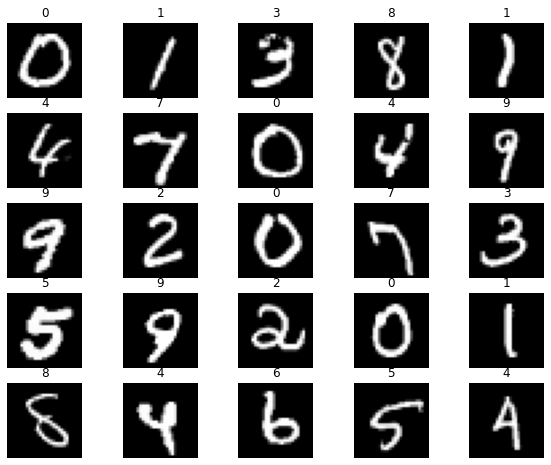

In [124]:
# Visualization of MNIST dataset
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [44]:
# Preparing data for training with DataLoaders
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
}

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=1)


# Definição da classe `CNN1`
A classe `CNN1` é subclasse de `nn.Module`, classe padrão do próprio `pytorch` para definição de redes neurais. As seguintes camadas compõem tal modelo:

O modelo `CNN1` é composto por três camadas lineares.
- `conv1`: Canais de entrada 1 / Canais de saída 16 / Maxpolling com kernel de tamanho 2
- `conv2`: Canais de entrada 16 / Canais de saída 32 / Maxpolling com kernel de tamanho 2
- `out`: Entrada (7 * 7 * 32) e saída 10 (representando as 10 classes presentes no `MINIST`.

In [126]:
# Define the Convolutional Neural Network models

# Define CNN1 Class 
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=kernel_size,              
                stride=stride,                   
                padding=padding,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, number_of_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

# Definição da classe `CNN2`
A classe `CNN2` é subclasse de `nn.Module`, classe padrão do próprio `pytorch` para definição de redes neurais. As seguintes camadas compõem tal modelo:

O modelo `CNN2` é composto por três camadas lineares.
- `conv1`: Canais de entrada 1 / Canais de saída 16 / Maxpolling com kernel de tamanho 2
- `conv2`: Canais de entrada 16 / Canais de saída 32 / Maxpolling com kernel de tamanho 2
- `conv3`: Canais de entrada 32 / Canais de saída 64 / Maxpolling com kernel de tamanho 2
- `out` 3: Entrada (3 * 3 * 64) e saída 10 (representando as 10 classes presentes no `MINIST`.

In [127]:
# Define CNN2 Class 
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=stride,                   
                padding=padding,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(64 * 3 * 3, number_of_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv2 to (batch_size, 64 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

# Definição da classe `CNN3`
A classe `CNN3` é subclasse de `nn.Module`, classe padrão do próprio `pytorch` para definição de redes neurais. As seguintes camadas compõem tal modelo:

O modelo `CNN3` é composto por três camadas lineares.
- `conv1`: Canais de entrada 1 / Canais de saída 16 / Maxpolling com kernel de tamanho 2
- `conv2`: Canais de entrada 16 / Canais de saída 32 / Maxpolling com kernel de tamanho 2
- `conv3`: Canais de entrada 32 / Canais de saída 64 / Maxpolling com kernel de tamanho 2
- `conv4`: Canais de entrada 64 / Canais de saída 128 / Maxpolling com kernel de tamanho 2
- `out` 3: Entrada (1 * 1 * 128) e saída 10 (representando as 10 classes presentes no `MINIST`.

In [128]:
# Define CNN3 Class 
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=kernel_size,              
                stride=stride,                   
                padding=padding,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(64, 128, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(128 * 1 * 1, number_of_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten the output of conv2 to (batch_size, 128 * 1 * 1)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

# Definição da classe `CNN4`
A classe `CNN4` é subclasse de `nn.Module`, classe padrão do próprio `pytorch` para definição de redes neurais. As seguintes camadas compõem tal modelo:

O modelo `CNN4` é composto por três camadas lineares.
- `conv1`: Canais de entrada 1 / Canais de saída 16 / Maxpolling com kernel de tamanho 2
- `conv2`: Canais de entrada 16 / Canais de saída 32 / Maxpolling com kernel de tamanho 2
- `conv3`: Canais de entrada 32 / Canais de saída 64 / Maxpolling com kernel de tamanho 2
- `conv4`: Canais de entrada 64 / Canais de saída 128 / Maxpolling com kernel de tamanho 2
- `conv5`: Canais de entrada 128 / Canais de saída 256 / Sem Maxpolling
- `out` 3: Entrada (1 * 1 * 256) e saída 10 (representando as 10 classes presentes no `MINIST`.

In [129]:
# Define CNN4 Class 
class CNN4(nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=kernel_size,              
                stride=stride,                   
                padding=padding,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(64, 128, kernel_size, stride, padding),     
            nn.ReLU(),
            nn.MaxPool2d(2),             
        )
        self.conv5 = nn.Sequential(         
            nn.Conv2d(128, 256, kernel_size, stride, padding),     
            nn.ReLU()               
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(256 * 1 * 1, number_of_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # flatten the output of conv2 to (batch_size, 256 * 1 * 1)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

# Definição da classe `CNN5`
A classe `CNN5` é subclasse de `nn.Module`, classe padrão do próprio `pytorch` para definição de redes neurais. As seguintes camadas compõem tal modelo:

O modelo `CNN5` é composto por três camadas lineares.
- `conv1`: Canais de entrada 1 / Canais de saída 16 / Maxpolling com kernel de tamanho 2
- `conv2`: Canais de entrada 16 / Canais de saída 32 / Maxpolling com kernel de tamanho 2
- `conv3`: Canais de entrada 32 / Canais de saída 64 / Maxpolling com kernel de tamanho 2
- `conv4`: Canais de entrada 64 / Canais de saída 128 / Maxpolling com kernel de tamanho 2
- `conv4`: Canais de entrada 64 / Canais de saída 128 / Maxpolling com kernel de tamanho 2
- `conv5`: Canais de entrada 128 / Canais de saída 256 / Sem Maxpolling
- `conv6`: Canais de entrada 256 / Canais de saída 512 / Sem Maxpolling
- `out` 3: Entrada (1 * 1 * 512) e saída 10 (representando as 10 classes presentes no `MINIST`.

In [130]:
# Define CNN5 Class 
class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=kernel_size,              
                stride=stride,                   
                padding=padding,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(64, 128, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv5 = nn.Sequential(         
            nn.Conv2d(128, 256, kernel_size, stride, padding),     
            nn.ReLU(),              
        )
        self.conv6 = nn.Sequential(         
            nn.Conv2d(256, 512, kernel_size, stride, padding),     
            nn.ReLU(),             
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(512 * 1 * 1, number_of_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

# Treinamento e avaliação dos modelos

Configurações utilizadas:
- Taxa de aprendizado: `0.01`
- Critério para `loss function`: `CrossEntropyLoss`
- Otimizador: `Adam`
- Números de épocas: `10`

In [49]:
# Define loss function
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [132]:
# Train the model
def train(num_epochs, cnn_model, loaders):
    average_loss_by_epoch = []
    print("Trainning phase - model ", type(cnn_model), "\n\n")
    print(cnn_model, "\n")
    start_time = time.time()
    # Define a Optimization Function
    optimizer = optim.Adam(cnn_model.parameters(), lr = learning_rate)   
    
    cnn_model.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        loss_sum = 0
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn_model(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()

            loss_sum += loss.item()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                
        average_loss_by_epoch.append(loss_sum/total_step)
    print("\n--- %s seconds spent during trainning ---" % (time.time() - start_time))
    return average_loss_by_epoch

In [133]:
# Evaluate the model on test data
def test(cnn_model):
    print("\n\nEvaluating models on test data - model ", type(cnn_model))
    cnn_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn_model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    
        print('Test Accuracy of the model on the 10000 test images: %.4f' % accuracy)

In [134]:
# Print 10 predictions from test data
def predict_sample_classes(cnn_model):
  sample = next(iter(loaders['test']))
  imgs, lbls = sample

  actual_number = lbls[:10].numpy()

  print("\nPredicting classes - model ", type(cnn_model))
  test_output, last_layer = model(imgs[:10])
  pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
  print(f'Prediction number: {pred_y}')
  print(f'Actual number: {actual_number}')

In [135]:
# Plot line chart - Average loss by epoch
def plot_average_loss_by_epoch(y):
  plt.title("Trainning - Average loss by epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Average loss")
  plt.plot(epochs_array, y, color ="red")
  plt.show()
  print(y)


In [147]:
# Plot multiple lines chart - Average loss by epoch
def plot_average_loss_by_epoch_multiple_lines(y_list):
  plt.title("Trainning - Average loss by epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Average loss")
  for y in y_list:
    plt.plot(epochs_array, y, color ="red")
  plt.show()
  print(y)

## Treinamento e avaliação do modelo `CNN1`

Trainning phase - model  <class '__main__.CNN1'> 


CNN1(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
) 

Epoch [1/10], Step [100/600], Loss: 0.1293
Epoch [1/10], Step [200/600], Loss: 0.1455
Epoch [1/10], Step [300/600], Loss: 0.0683
Epoch [1/10], Step [400/600], Loss: 0.0532
Epoch [1/10], Step [500/600], Loss: 0.0772
Epoch [1/10], Step [600/600], Loss: 0.0689
Epoch [2/10], Step [100/600], Loss: 0.0361
Epoch [2/10], Step [200/600], Loss: 0.1349
Epoch [2/10], Step [300/600], Loss: 0.0275
Epoch [2/10], Step [400/600], Loss: 0.0364
Epoch [2/10], Step [500/600], Loss: 0.0323


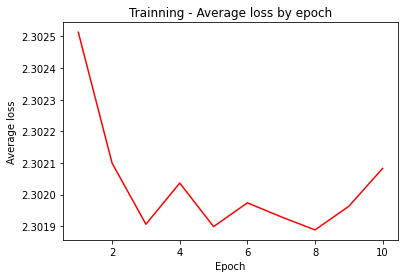

[2.3025133617719016, 2.3020991269747415, 2.3019060091177623, 2.302036247253418, 2.301898525953293, 2.301973685026169, 2.3019293920199075, 2.301888023217519, 2.3019627392292024, 2.3020827718575796]


Evaluating models on test data - model  <class '__main__.CNN1'>
Test Accuracy of the model on the 10000 test images: 0.9900

Predicting classes - model  <class '__main__.CNN1'>
Prediction number: [5 9 8 6 0 3 0 0 8 6]
Actual number: [5 9 8 6 0 3 0 0 8 6]


In [136]:
#Train and test model CNN1
cnn1 = CNN1()
average_loss_by_epoch_cnn1 = train(num_epochs, cnn1, loaders)
plot_average_loss_by_epoch(average_loss_by_epoch)
test(cnn1)
predict_sample_classes(cnn1)

## Treinamento e avaliação do modelo `CNN2`

Trainning phase - model  <class '__main__.CNN2'> 


CNN2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=576, out_features=10, bias=True)
) 

Epoch [1/10], Step [100/600], Loss: 0.1529
Epoch [1/10], Step [200/600], Loss: 0.1024
Epoch [1/10], Step [300/600], Loss: 0.0638
Epoch [1/10], Step [400/600], Loss: 0.0794
Epoch [1/10], Step [500/600], Loss: 0.0650
Epoch [1/10], Step [600/600], Loss: 0.0858
Epoch [2/10], 

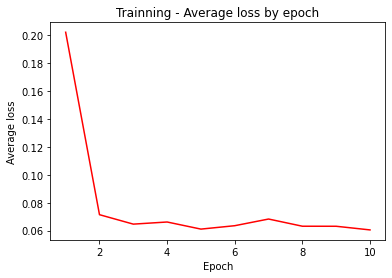

[0.20210939378400022, 0.07141751121496781, 0.06465506039608347, 0.0661790271885305, 0.06108820291337906, 0.06352959081423858, 0.06830455450244093, 0.06314986412224244, 0.06312077680137008, 0.06050777429326748]


Evaluating models on test data - model  <class '__main__.CNN2'>
Test Accuracy of the model on the 10000 test images: 0.9400

Predicting classes - model  <class '__main__.CNN2'>
Prediction number: [1 3 2 2 9 2 8 4 8 3]
Actual number: [1 3 2 2 9 2 8 4 8 3]


In [137]:
#Train and test model CNN2
cnn2 = CNN2()
average_loss_by_epoch_cnn2 = train(num_epochs, cnn2, loaders)
plot_average_loss_by_epoch(average_loss_by_epoch_cnn2)
test(cnn2)
predict_sample_classes(cnn2)

## Treinamento e avaliação do modelo `CNN3`

Trainning phase - model  <class '__main__.CNN3'> 


CNN3(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=128, out_features=10, bias=True)
) 

Epoch [1/10], Step [100/600], Loss: 2.2892
Epoch [1/10], Step [200/60

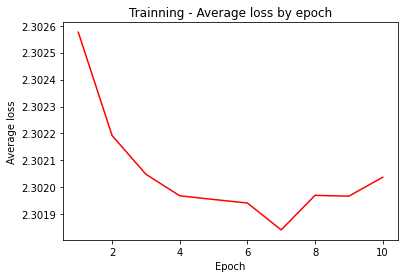

[2.3025757614771525, 2.302192023595174, 2.3020485961437225, 2.301968560218811, 2.3019549385706584, 2.3019418545564014, 2.301841923793157, 2.3019702192147573, 2.301967275937398, 2.3020372955004373]


Evaluating models on test data - model  <class '__main__.CNN3'>
Test Accuracy of the model on the 10000 test images: 0.1700

Predicting classes - model  <class '__main__.CNN3'>
Prediction number: [3 5 7 7 2 5 3 4 9 3]
Actual number: [3 5 7 7 2 5 3 4 9 3]


In [138]:
#Train and test model CNN3
cnn3 = CNN3()
average_loss_by_epoch_cnn3 = train(num_epochs, cnn3, loaders)
plot_average_loss_by_epoch(average_loss_by_epoch_cnn3)
test(cnn3)
predict_sample_classes(cnn3)

## Treinamento e avaliação do modelo `CNN4`

Trainning phase - model  <class '__main__.CNN4'> 


CNN4(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (out): Linea

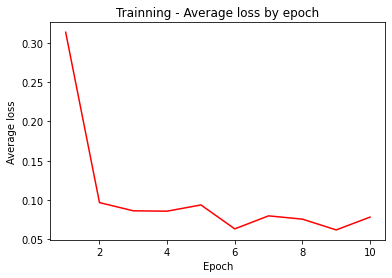

[0.3135378984788743, 0.09677767292091934, 0.08634443084379503, 0.0858737520436019, 0.09380170336352119, 0.06336085938411998, 0.07993340452701281, 0.075738210787628, 0.062033377349483394, 0.07831957369189088]


Evaluating models on test data - model  <class '__main__.CNN4'>
Test Accuracy of the model on the 10000 test images: 0.9800

Predicting classes - model  <class '__main__.CNN4'>
Prediction number: [2 1 3 0 7 3 8 6 1 6]
Actual number: [2 1 3 0 7 3 8 6 1 6]


In [139]:
#Train and test model CNN4
cnn4 = CNN4()
average_loss_by_epoch_cnn4 = train(num_epochs, cnn4, loaders)
plot_average_loss_by_epoch(average_loss_by_epoch_cnn4)
test(cnn4)
predict_sample_classes(cnn4)

## Treinamento e avaliação do modelo `CNN5`

Trainning phase - model  <class '__main__.CNN5'> 


CNN5(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (conv6): Seq

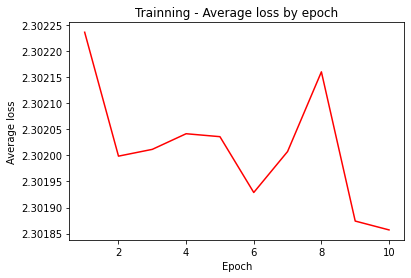

[2.3022362844149273, 2.3019985592365266, 2.3020115760962168, 2.30204155921936, 2.3020359071095786, 2.3019288182258606, 2.302007399002711, 2.302160294055939, 2.3018740117549896, 2.3018570073445637]


Evaluating models on test data - model  <class '__main__.CNN5'>
Test Accuracy of the model on the 10000 test images: 0.1200

Predicting classes - model  <class '__main__.CNN5'>
Prediction number: [5 6 0 3 4 9 1 8 9 1]
Actual number: [5 6 0 3 4 9 1 8 9 1]


In [141]:
#Train and test model CNN5
cnn5 = CNN5()
average_loss_by_epoch_cnn5 = train(num_epochs, cnn5, loaders)
plot_average_loss_by_epoch(average_loss_by_epoch_cnn5)
test(cnn5)
predict_sample_classes(cnn5)

# Análise sobre os resultados obtidos nos modelos `CNN`

## Average Loss

A seguir, apresentamos uma tabela comparativa do `average loss` para cada época de treinamento para cada um dos modelos avaliados.
Foram utilizadas 10 épocas na etapa de treinamento. Os modelos `CNN2` (`0.06050777 `) e `CNN4` (`0.07831957`) foram os que apresentaram menor `loss` ao final da última época de treinamento.Os demais modelos tiveram resultado parecido com `loss` aproximado de `~2.30`.


In [27]:
loss_cnn1 = [2.3025133617719016, 2.3020991269747415, 2.3019060091177623, 2.302036247253418, 2.301898525953293, 2.301973685026169, 2.3019293920199075, 2.301888023217519, 2.3019627392292024, 2.3020827718575796]
loss_cnn2 = [0.20210939378400022, 0.07141751121496781, 0.06465506039608347, 0.0661790271885305, 0.06108820291337906, 0.06352959081423858, 0.06830455450244093, 0.06314986412224244, 0.06312077680137008, 0.06050777429326748]
loss_cnn3 = [2.3025757614771525, 2.302192023595174, 2.3020485961437225, 2.301968560218811, 2.3019549385706584, 2.3019418545564014, 2.301841923793157, 2.3019702192147573, 2.301967275937398, 2.3020372955004373]
loss_cnn4 = [0.3135378984788743, 0.09677767292091934, 0.08634443084379503, 0.0858737520436019, 0.09380170336352119, 0.06336085938411998, 0.07993340452701281, 0.075738210787628, 0.062033377349483394, 0.07831957369189088]
loss_cnn5 = [2.3022362844149273, 2.3019985592365266, 2.3020115760962168, 2.30204155921936, 2.3020359071095786, 2.3019288182258606, 2.302007399002711, 2.302160294055939, 2.3018740117549896, 2.3018570073445637]

table_headers = ['CNN1', 'CNN2', 'CNN3', 'CNN4', 'CNN5']
loss_matrix = np.array([loss_cnn1, loss_cnn2, loss_cnn3, loss_cnn4, loss_cnn5])
loss_matrix = loss_matrix.transpose()

print(table_headers)
print(loss_matrix)

['CNN1', 'CNN2', 'CNN3', 'CNN4', 'CNN5']
[[2.30251336 0.20210939 2.30257576 0.3135379  2.30223628]
 [2.30209913 0.07141751 2.30219202 0.09677767 2.30199856]
 [2.30190601 0.06465506 2.3020486  0.08634443 2.30201158]
 [2.30203625 0.06617903 2.30196856 0.08587375 2.30204156]
 [2.30189853 0.0610882  2.30195494 0.0938017  2.30203591]
 [2.30197369 0.06352959 2.30194185 0.06336086 2.30192882]
 [2.30192939 0.06830455 2.30184192 0.0799334  2.3020074 ]
 [2.30188802 0.06314986 2.30197022 0.07573821 2.30216029]
 [2.30196274 0.06312078 2.30196728 0.06203338 2.30187401]
 [2.30208277 0.06050777 2.3020373  0.07831957 2.30185701]]


## Acurácia - Dados de teste

Após a etapa de treinamento, foi avaliada a acurácia de cada um dos modelos, utilizando os dados de teste. A seguir, apresentamos as acurácias vericadas:
- `CNN1`: `0.9900`
- `CNN2`: `0.9400`
- `CNN3`: `0.1700`
- `CNN4`: `0.9800`
- `CNN5`: `0.1200`

Analisando os valores de acurácia acima, notamos que não existe uma relação direta entre sucesso na fase de treinamento (baixo `loss average`) e sucesso na fase de teste (alta acurácia). Um exemplo disto é o modelo `CNN1`, que embora tenha apresentada `loss average` de `2.30208277`, também foi o modelo com maior acurácia na fasa de testes: `0.9900`.

# Comparação do `CNN` com a Multilayer Perceptron

A seguir, vamos verificar a eficácia do modelo `Multilayer Perceptron - MLP`   para a resolução no mesmo problema de classicação com a base de dados `MNIST`.

O seguinte repositório do ***github*** foi utilizado como referência: https://github.com/iam-mhaseeb/Multi-Layer-Perceptron-MNIST-with-PyTorch/blob/master/mnist_mlp_exercise.ipynb

Para que seja uma comparação significativa, foram aplicadas as mesmas configurações utilizadas nos modelos `CNN`, porém com um número maior de épocas de treinamento:
- Taxa de aprendizado: `0.01`
- Critério para `loss function`: `CrossEntropyLoss`
- Otimizador: `Adam`
- Números de épocas: `30`

In [32]:
## Define the MPL model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        return x

# initialize the MLP
mlp = MLP()
print(mlp)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [61]:
# number of epochs to train the model
n_epochs = 30  # suggest training between 20-50 epochs

mlp.train() # prep model for training

optimizer_mlp = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer_mlp.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = loss_func(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_mlp.step()
        # update running training loss
        train_loss += loss.item()
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.003418
Epoch: 2 	Training Loss: 0.003142
Epoch: 3 	Training Loss: 0.003056
Epoch: 4 	Training Loss: 0.003005
Epoch: 5 	Training Loss: 0.002969
Epoch: 6 	Training Loss: 0.002942
Epoch: 7 	Training Loss: 0.002921
Epoch: 8 	Training Loss: 0.002903
Epoch: 9 	Training Loss: 0.002888
Epoch: 10 	Training Loss: 0.002876
Epoch: 11 	Training Loss: 0.002864
Epoch: 12 	Training Loss: 0.002854
Epoch: 13 	Training Loss: 0.002845
Epoch: 14 	Training Loss: 0.002835
Epoch: 15 	Training Loss: 0.002827
Epoch: 16 	Training Loss: 0.002819
Epoch: 17 	Training Loss: 0.002813
Epoch: 18 	Training Loss: 0.002806
Epoch: 19 	Training Loss: 0.002800
Epoch: 20 	Training Loss: 0.002795
Epoch: 21 	Training Loss: 0.002790
Epoch: 22 	Training Loss: 0.002785
Epoch: 23 	Training Loss: 0.002781
Epoch: 24 	Training Loss: 0.002777
Epoch: 25 	Training Loss: 0.002774
Epoch: 26 	Training Loss: 0.002771
Epoch: 27 	Training Loss: 0.002767
Epoch: 28 	Training Loss: 0.002762
Epoch: 29 	Training Loss: 0.0

In [63]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = loss_func(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.416484

Test Accuracy of     0: 97% (956/980)
Test Accuracy of     1: 98% (1115/1135)
Test Accuracy of     2: 81% (845/1032)
Test Accuracy of     3: 81% (820/1010)
Test Accuracy of     4: 92% (910/982)
Test Accuracy of     5: 94% (841/892)
Test Accuracy of     6: 89% (860/958)
Test Accuracy of     7: 89% (923/1028)
Test Accuracy of     8: 85% (830/974)
Test Accuracy of     9: 91% (922/1009)

Test Accuracy (Overall): 90% (9022/10000)


## Avaliação dos resultados - CNN x MPL

Foram utilizadas 30 épocas para o treinamento da rede `MLP` e 10 épocas para os modelos `CNN`. Ao final da última época, foi verificado um valor de `average loss` de `0.002756` para o modelo `MLP`. Para os modelos `CNN`, o melhor valor foi durante o treinamento do `CNN2` com o valor de `0.06050777`.

Embora o `average loss` do modelo `MLP` tenha sido imensamente menor, tivemos boa acurácia para os dois modelos quando avaliamos os dados de teste, com valores iguais ou superiores a 90%.

Concluímos que é possível resolver o problema de classificação da base de dados `MNIST` com ambos modelos: `CNN` e `MLP`. Entretanto, o modelo `MLP` é muito mais rápido de ser treinado, pois possui menor complexidade envolvida. Logo, na prática seria possivelmente o modelo escolhido por ser mais simples e mais rápido, fornecendo uma acurácia similar aos melhores modelos `CNN`.